# Exploratary Data Analysis on EdX Data (2013-14)

In [74]:
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sb

# EdX Dataset 


The dataset contains data about particpants who enrolled in MITx and HarvardX courses on EdX platform (Academic Year 2013: Fall 2012, Spring 2013, and Summer 2013). The data includes  aggregate records of participants activities on EdX (which some information such as 'user name' de-identified). The dataset has been downloaded from 

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/26147&version=10.0



In [75]:
# PATH to data file
file='HMXPC13_DI_v2_5-14-14.csv'
path='/Users/suka/Downloads/dataverse_files'
filename=path+'/'+file

# Description of the DataSet  

* **course_id** unique identifier with information about institution , course name and semester
* **userid_DI:** identifies  user / course participant 
* **registered** registered for course, (=1 for all records ) 
* **viewed:**  indicates the user has viewed the course content 
* **explored** indicates user has  accessed at least half of the chapters in the courseware 
* **certified** indicates the user has completed the course with passing grade 
* **final_cc_cname_DI** indicates the country / region of the user
* **LoE** level of education of the user
* **YoB** user-provided, year of birth. 
* **gender** user-provided. Possible values: m (male), f (female) and o (other). 
* **grade** final grade of the user  i
* **start_time_DI**  date of course registration.
* **last_event_DI** date of last interaction with course,
* **nevents** number of interactions with the course,
* **ndays_act** number of unique days student interacted with course.
* **nplay_video** number of play video events within the course. Example: “52”. 
* **nchapters**  number of chapters  completed by the student 
* **inconsistent_flag** identifies records that are internally inconsistent. 



In [72]:
#  READ THE CSV to data frame 
full_df = pd.read_csv(filename,parse_dates=True)
len(full_df)

641138

In [73]:
len(full_df[full_df.certified==1])

17687

A quick check shows that we have over 640000 student records in the dataset of which only ~17000 have completed the course certification !

# Cleanup
Before we go any further, we need to convert/clean the dataset . Here are the changes done
* drop the dataset which user specified information ( YoB,Education,Gender ) incomplete
* split the course_id to retrieve institution , course name and semester / year
* map the course-id/code to course title (eg 'CS50x':'Computer Science')
* rename the column headings appropriately
* fill NaN with 0 values
* Insert "Age" column
* Set the datatypes of the columns appropriately
* add categorical order for the education level 
* convert the grade(0 to 1) to %

In [123]:
#filter out rows which do not have data for DoB , Education, etc
valid_rows = np.logical_and.reduce((full_df['YoB'].notnull(),full_df['gender'].notnull(),full_df['LoE_DI'].notnull()))
df = full_df[valid_rows] # extract the rows with complete data

# Extract relevant fields 
data = df[['course_id','userid_DI','final_cc_cname_DI','LoE_DI','YoB','gender','start_time_DI','grade','viewed','explored','nevents','ndays_act','nplay_video','nchapters','certified','registered','incomplete_flag']]

# split the course id into multiple fields
a,b,c = data['course_id'].str.split('/').str
data.insert(1,'institution',a)
data.insert(2,'course',b)

# clean up the year which has the _spring,_fall suffixes 
c = c.str.split('_').str[0]
data.insert(3,'year',c)
data.drop('course_id',axis=1,inplace=True)

# Create the mapping of course-id to title 
courselist = {'CB22x':'Greek Heros', 'CS50x':'Computer Science','ER22x':'Justice','PH207x':'Health Stat','PH278x':'Health Env','14.73x':'Poverty','2.01x':'Structures','3.091x':'SS Chemistry','6.002x':'Circuits','6.00x':'Computer Pgming','7.00x':'Biology','8.02x':'Electricity & Magnetism','8.MReV':'Mechanics'}
data['course'].replace(courselist, inplace=True)

#rename columns 
data.rename(columns={'course_id': 'course', 'final_cc_cname_DI': 'country','LoE_DI':'education','userid_DI':'user',"start_time_DI":"start-time"}, inplace=True)


#Fill NaN data with zeros
data.fillna(0,inplace=True) # replace NaN with 0 

# change the datatypes of some of the columns
data['institution']= data.institution.astype('category')
data['course']= data.course.astype('category')

e_order = ["Less than Secondary","Secondary","Bachelor's","Master's","Doctorate"]



data['grade'] = pd.to_numeric(data['grade'],errors='coerce')
data['grade'] = data['grade'].fillna(0).multiply(100)
#data['grade'] = data['grade'].multiply(100)
#data['grade'] = data.grade.astype('int')


#data.insert(3,"age", [(x.year-x.YoB) for index, x in data.iterrows() ])
data['education']= data.education.astype('category',ordered=True,categories=e_order)
data['gender']= data.gender.astype('category')
data['year']= data.year.astype('int')
data['YoB']= data.YoB.astype('int')
data['nevents']= data.nevents.astype('int')
data['nchapters']= data.nchapters.astype('int')
data['ndays_act']= data.ndays_act.astype('int')
data['nplay_video']= data.nplay_video.astype('int')

data['start-time'] = pd.to_datetime(data['start-time'])


# Add a column "age" using YoB (age calculated as on 2014)
data.insert(3,"age", [(x.year-x.YoB) for index, x in data.iterrows() ])



/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Applications/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Applications/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2754: 

In [122]:
data.tail(1000)


#data.info()
#print(data[data['grade'].isnull()])

,institution,course,year,age,user,country,education,YoB,gender,start-time,grade,viewed,explored,nevents,ndays_act,nplay_video,nchapters,certified,registered,incomplete_flag
640030,MITx,Poverty,2013,37,MHxPC130176299,India,Bachelor's,1976,m,2013-09-03,0.0,1,0,80,1,0,1,0,1,0.0
640031,MITx,Computer Pgming,2013,35,MHxPC130206785,United States,Bachelor's,1978,m,2013-09-02,0.0,1,0,175,1,6,1,0,1,0.0
640032,MITx,Computer Pgming,2013,32,MHxPC130156268,China,Master's,1981,m,2013-09-02,0.0,1,0,23,2,3,1,0,1,0.0
640033,MITx,Computer Pgming,2013,23,MHxPC130251022,Unknown/Other,Bachelor's,1990,m,2013-09-02,0.0,0,0,0,0,0,0,0,1,0.0
640034,MITx,Poverty,2013,22,MHxPC130193897,India,Bachelor's,1991,m,2013-09-02,0.0,1,0,8,1,0,2,0,1,0.0
640035,MITx,Computer Pgming,2013,35,MHxPC130141881,Other South Asia,Master's,1978,m,2013-09-02,0.0,1,0,60,1,7,3,0,1,0.0
640036,MITx,Computer Pgming,2013,24,MHxPC130469815,India,Bachelor's,1989,m,2013-09-02,0.0,1,0,47,2,5,3,0,1,0.0
640037,MITx,Poverty,2013,26,MHxPC130591266,India,Master's,1987,f,2013-09-02,0.0,1,0,8,1,2,1,0,1,0.0
640038,MITx,Computer Pgming,2013,22,MHxPC130502516,India,Bachelor's,1991,m,2013-09-02,0.0,1,0,441,1,34,2,0,1,0.0
640039,MITx,Circuits,2013,20,MHxPC130270328,India,Bachelor's,1993,m,2013-09-02,0.0,0,0,17,1,0,0,0,1,0.0


In [77]:

print("Extracted "+str(len(data))+" clean records from "+str(len(full_df))+" in the originsl dataset")


Extracted 530046 clean records from 641138 in the originsl dataset


We now have over 530000 clean data records to work with 

In [80]:
data.head()

,institution,course,year,age,user,country,education,YoB,gender,start-time,grade,viewed,explored,nevents,ndays_act,nplay_video,nchapters,certified,registered,incomplete_flag
19329,HarvardX,Computer Science,2012,0,MHxPC130288276,United States,Secondary,2012,m,2013-08-30,0.0,0,0,0,0,0,0,0,1,0.0
19330,HarvardX,Computer Science,2012,25,MHxPC130422039,Unknown/Other,Secondary,1987,m,2012-07-24,0,0,0,0,0,0,0,0,1,0.0
19331,HarvardX,Computer Science,2012,44,MHxPC130407931,United States,Secondary,1968,f,2012-07-24,0,0,0,0,0,0,0,0,1,0.0
19332,HarvardX,Health Stat,2012,23,MHxPC130313697,India,Bachelor's,1989,m,2012-07-24,0,0,0,6,3,0,0,0,1,0.0
19333,HarvardX,Computer Science,2012,34,MHxPC130064950,Unknown/Other,Master's,1978,m,2012-07-24,0.0,0,0,0,0,0,0,0,1,0.0


# Let's pick a random subset for visualization/exploratory data analysis 
* Pick a random set of 10000 data points that we can use with visualization

In [124]:
# pick a random subset of 10000 data points 
rdm = np.random.choice(len(data), replace=False, size=10000)
data_trim = data.iloc[rdm]

# Course Completion Stats 

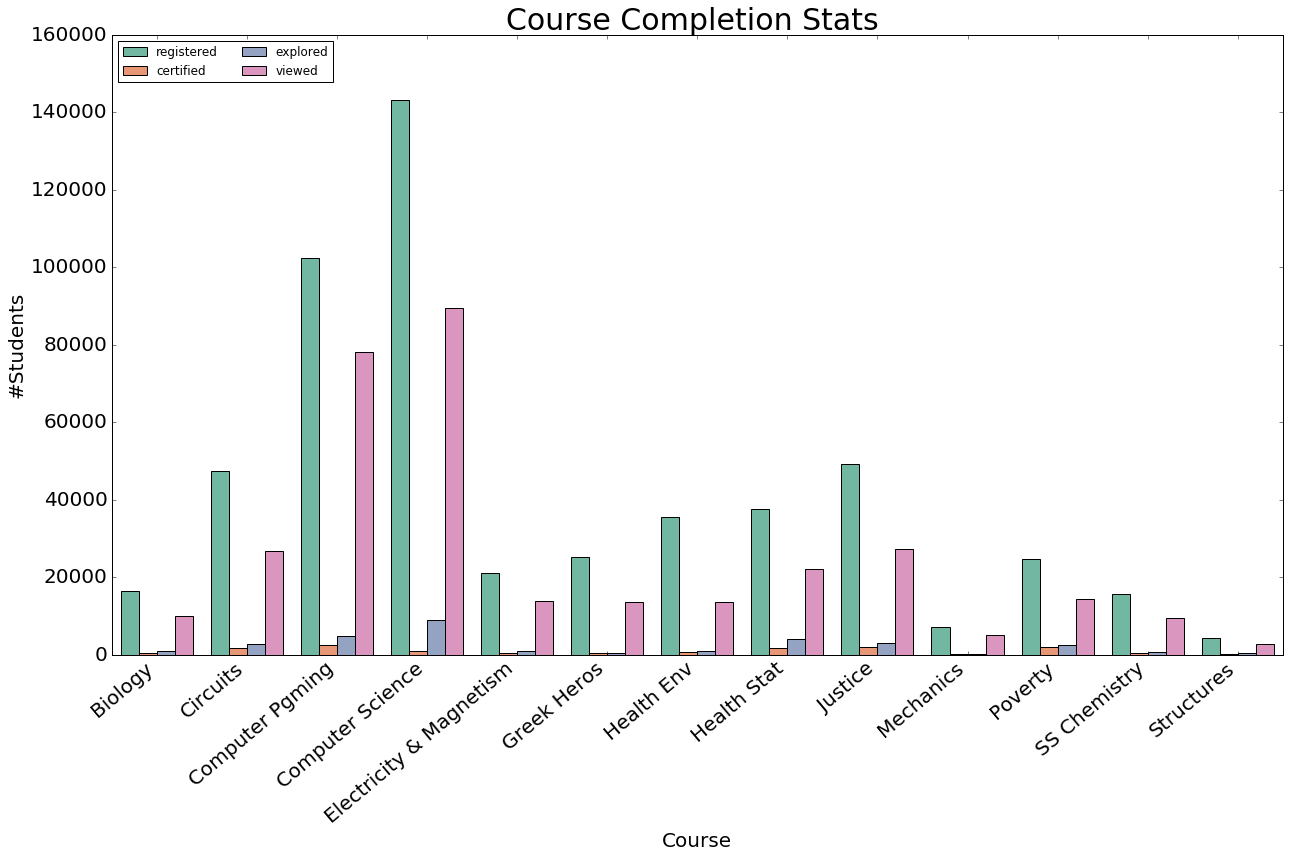

In [125]:
aggregations = { 'certified':'sum','registered':'sum','viewed':'sum','explored':'sum'}

%matplotlib inline

cdata = data.groupby(['course'],as_index=False).agg(aggregations)

tidydata = (
    cdata.set_index('course')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

%matplotlib inline
plt.figure(figsize=(18,12))
ax=sb.barplot(x='course', y='Value', hue='Variable', data=tidydata,palette="Set2")

ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axes.set_title('Course Completion Stats ',fontsize=30)
ax.tick_params(labelsize=20)
ax.set_ylabel('#Students',fontsize=20)
ax.set_xlabel('Course',fontsize=20)
ax.legend(ncol=2, loc='upper left');
plt.tight_layout()


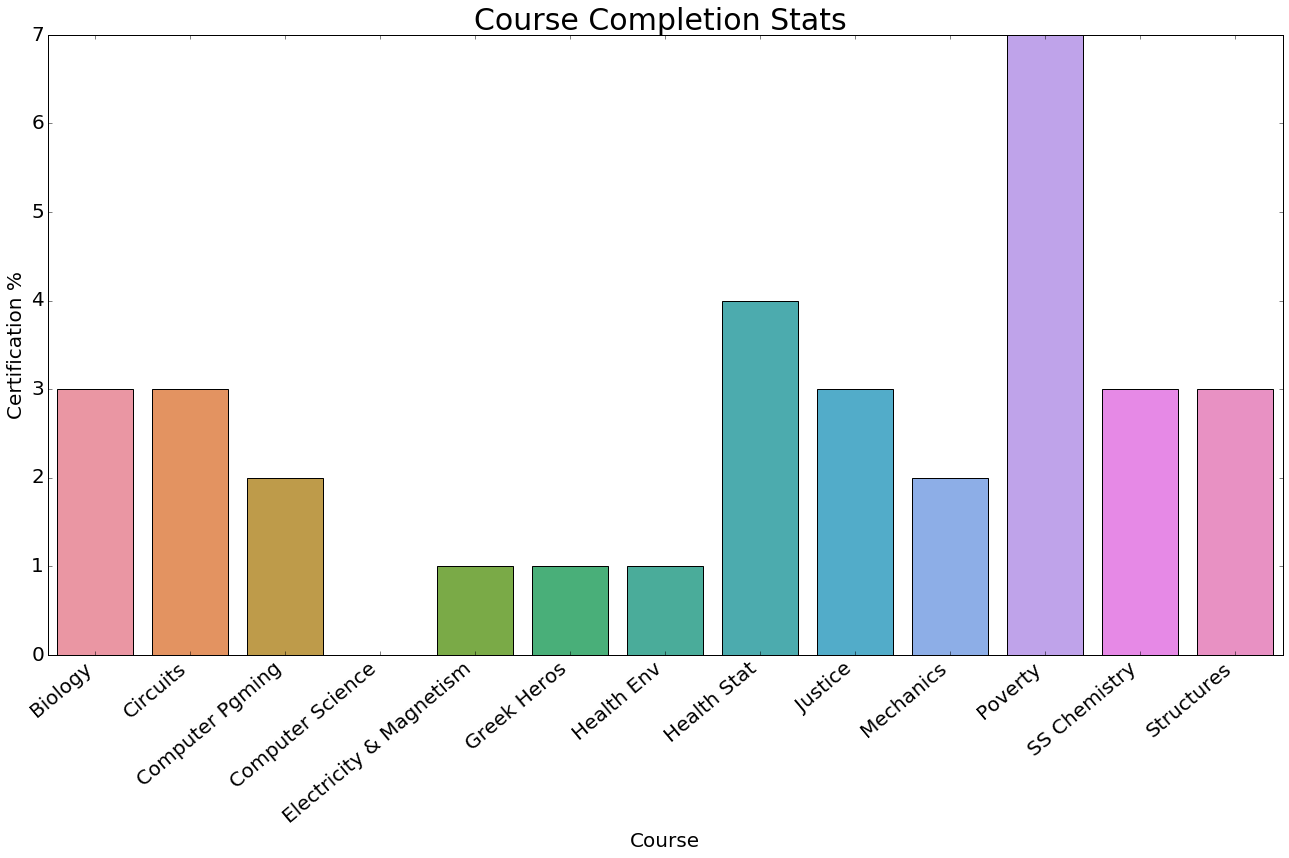

In [86]:
%matplotlib inline
# Extract the COURSE specific data and calculate the % %certification rate
course_data = data[['course','certified','registered']].groupby('course',as_index=False).sum()
course_data['rate'] = [ int(100 * x.certified / x.registered) for index, x in course_data.iterrows() ]

plt.figure(figsize=(18,12))

ax=sb.barplot(x="course", y="rate", data=course_data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.tick_params(labelsize=20)
ax.set_ylabel('Certification %',fontsize=20)
ax.set_xlabel('Course',fontsize=20)
ax.axes.set_title('Course Completion Stats ',fontsize=30)
plt.tight_layout()



/Applications/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


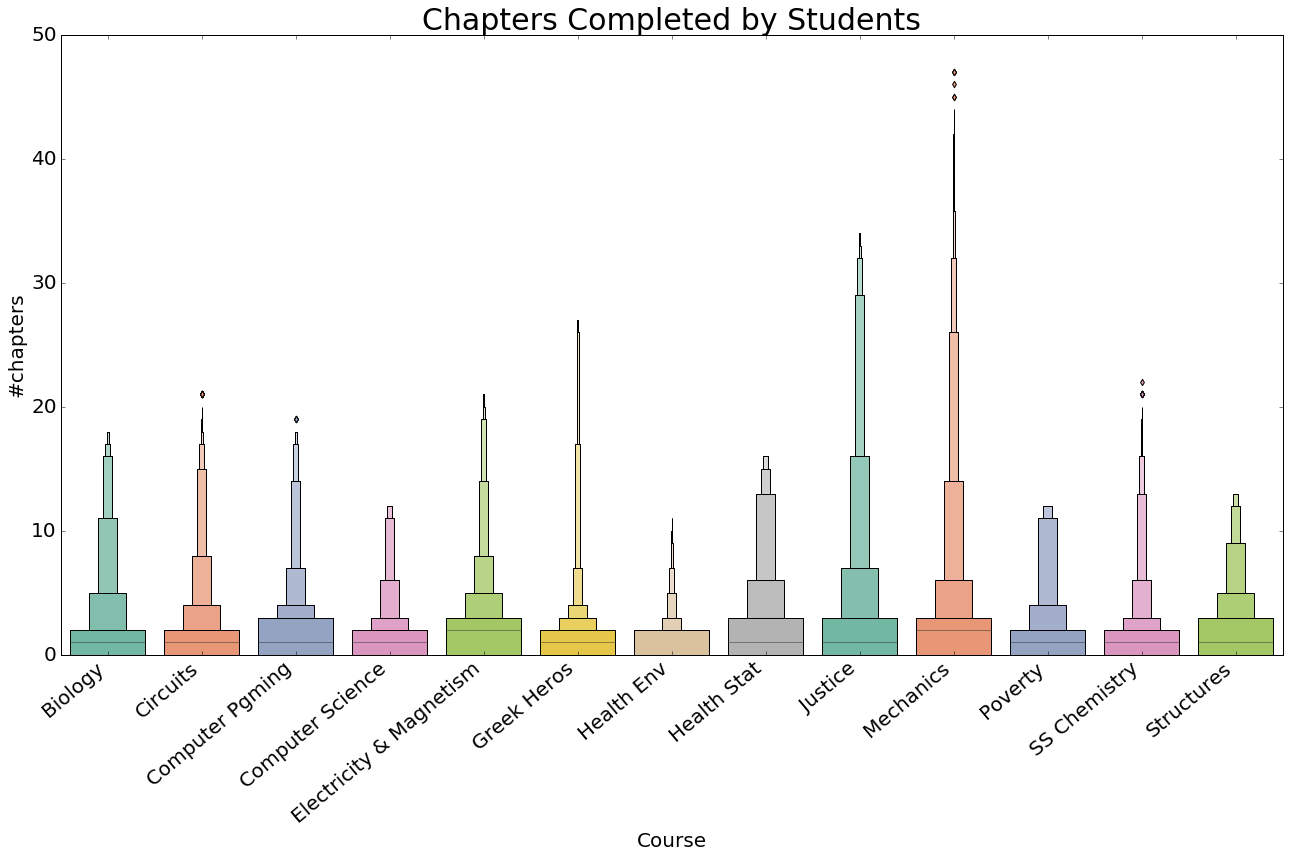

In [93]:
# NO of events/interactions on the course for the first 1000 
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.lvplot(x="course", y="nchapters",data=data,palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(ylim=(0,50))
ax.axes.set_title('Chapters Completed by Students',fontsize=30)
ax.tick_params(labelsize=20)
ax.set_ylabel('#chapters',fontsize=20)
ax.set_xlabel('Course',fontsize=20)
ax.legend(ncol=2, loc='upper left');
plt.tight_layout()


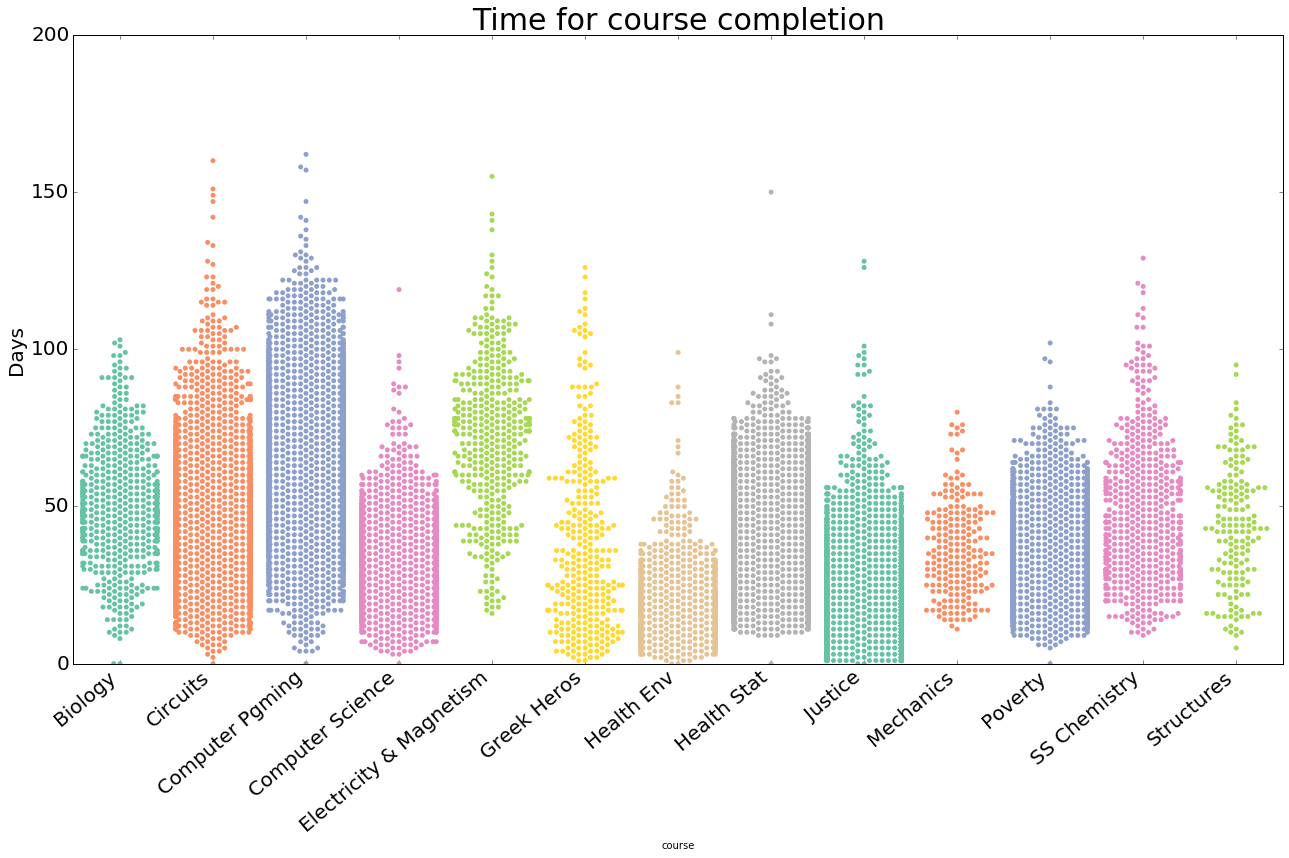

In [94]:
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.swarmplot(x="course", y="ndays_act", data=data[data.certified==1],palette="Set2", dodge=True)
ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Days',fontsize=20)
ax.axes.set_title('Time for course completion',fontsize=30)
ax.tick_params(labelsize=20)
plt.tight_layout()


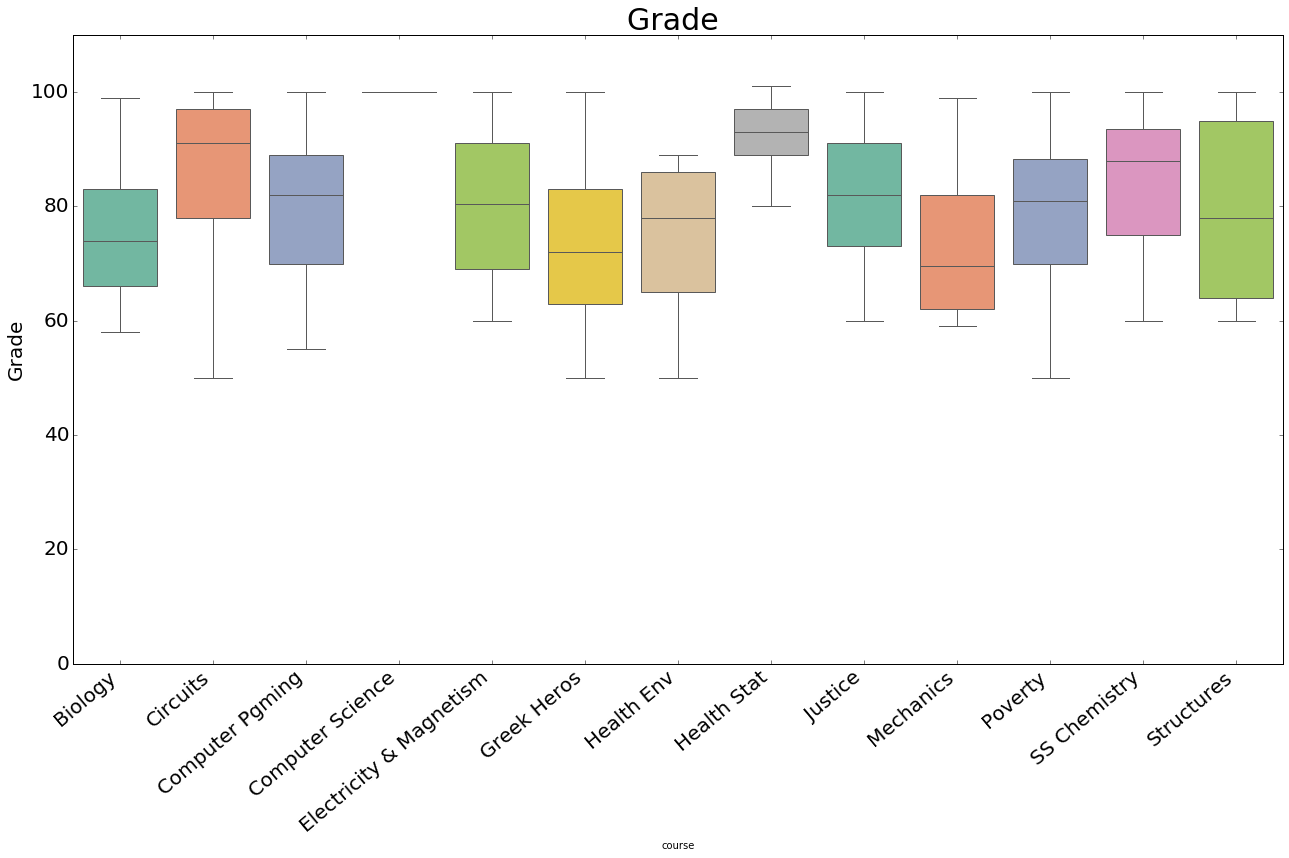

In [126]:
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.boxplot(x="course", y="grade", data=data[data.certified==1],palette="Set2", dodge=True)
ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Grade',fontsize=20)
ax.axes.set_title('Grade (students who completed course)',fontsize=30)
ax.tick_params(labelsize=20)
plt.tight_layout()



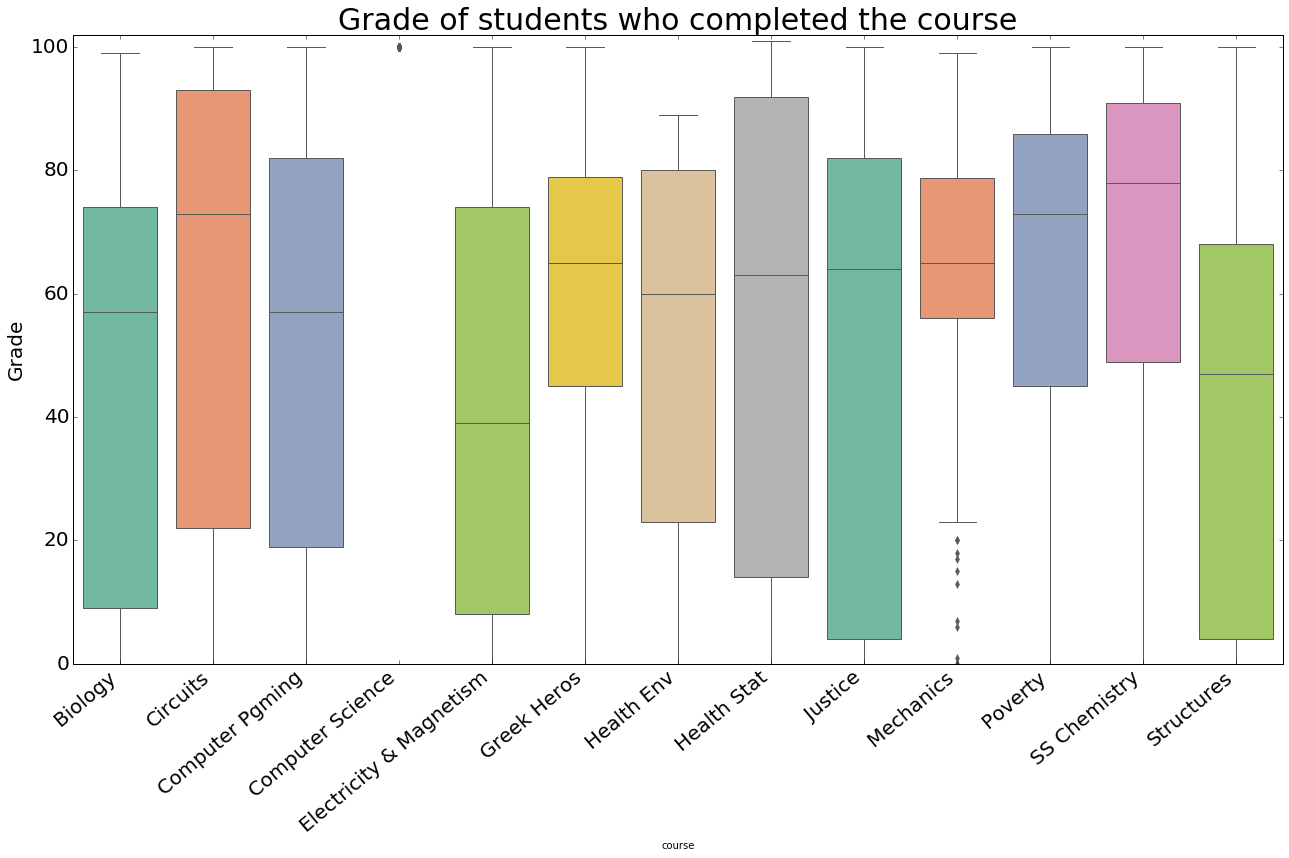

In [240]:
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.boxplot(x="course", y="grade", data=data[data.explored==1],palette="Set2", dodge=True)
ax.set(ylim=(0,102))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Grade',fontsize=20)
ax.axes.set_title('Grade of students who completed the course',fontsize=30)
ax.tick_params(labelsize=20)
plt.tight_layout()




Something incorrect with the code below - Looking for a plot of students who completed 50% of coursework , but still failed

In [172]:
#%matplotlib inline
#plt.figure(figsize=(18,12))

#ax = sb.boxplot(x="course", y="grade", data=data[[data.explored==1] and [data.certified==0]],palette="Set2", dodge=True)
#ax.set(ylim=(0,None))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set_ylabel('Grade',fontsize=20)
#ax.axes.set_title('Grade (students )',fontsize=30)
#ax.tick_params(labelsize=20)
#plt.tight_layout()



# Observations 
* For all courses number of students completing the course < 7% 
* Students enrolling in Computer Courses make up more than 40% of the dataset 
* CS course has the least certification rate 
* Median #chapters viewed is 0 for most courses <=1
* Days for course completion = 0 for some students??


# Age Distribution of participants 

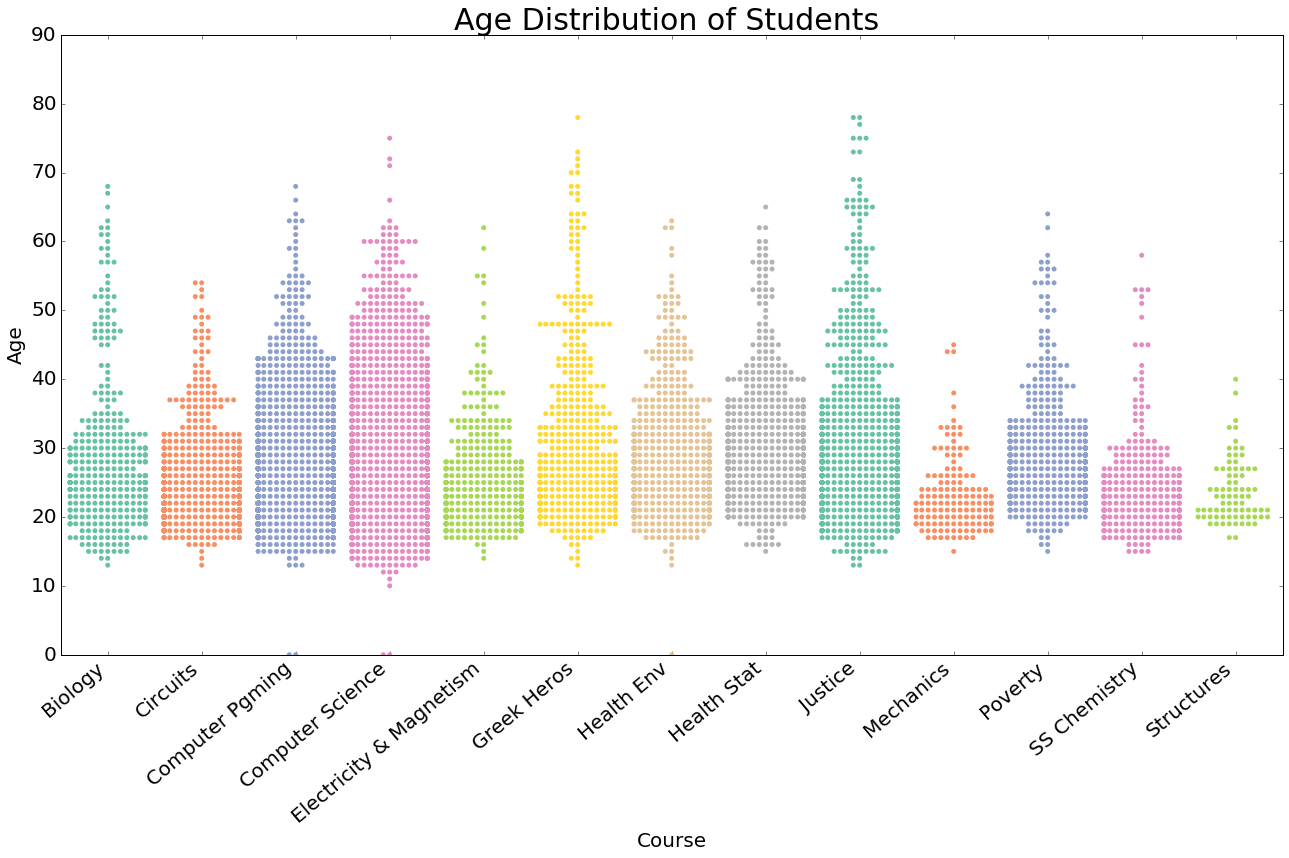

In [89]:
# Age distribution for  the course particpants using the randam subset 
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.swarmplot(x="course", y="age", data=data_trim,palette="Set2", dodge=True)
ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Age',fontsize=20)
ax.set_xlabel('Course',fontsize=20)
ax.axes.set_title('Age Distribution of Students ',fontsize=30)
ax.tick_params(labelsize=20)
plt.tight_layout()

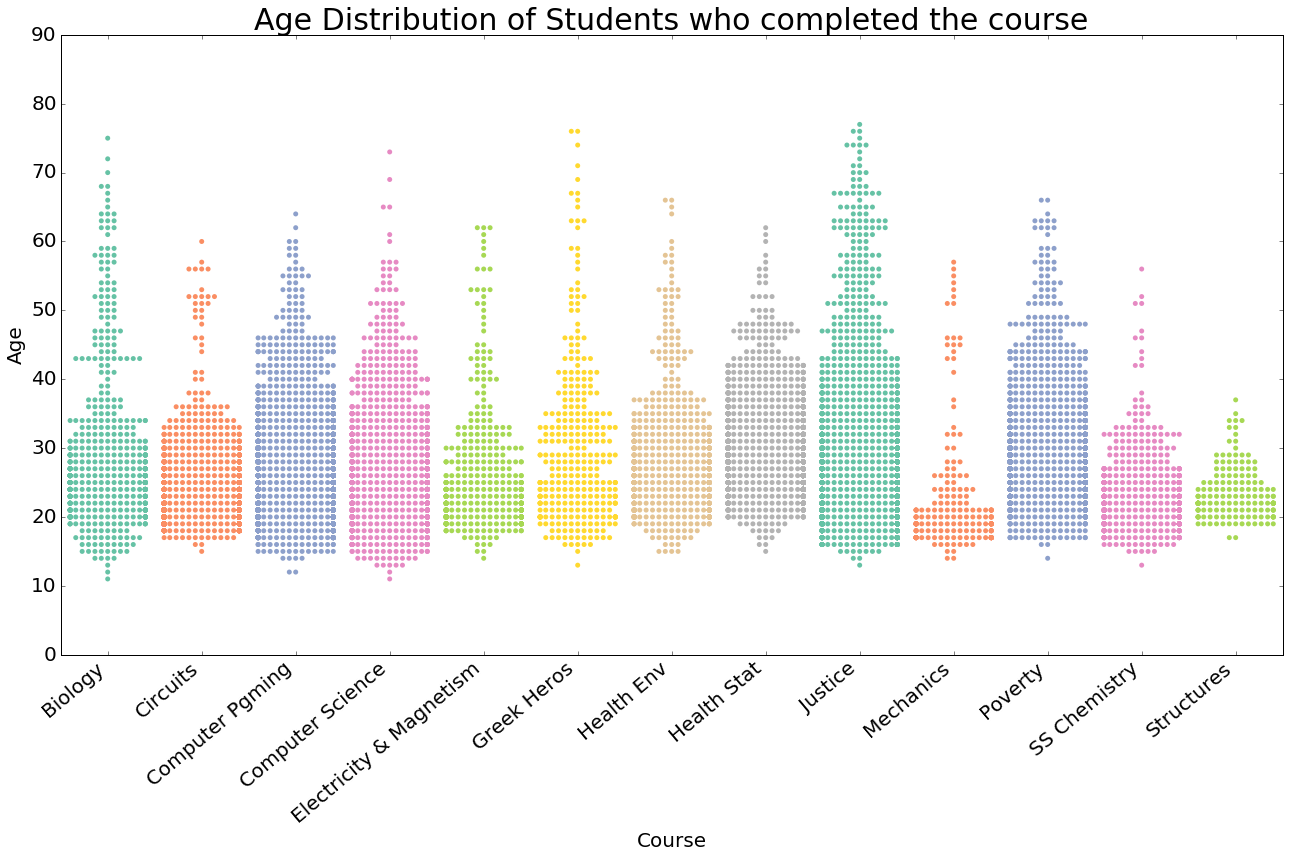

In [90]:
# Age distribution for  the course particpants using the randam subset 
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.swarmplot(x="course", y="age", data=data[data.certified==1],palette="Set2", dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(ylim=(0,None))
ax.axes.set_title('Age Distribution of Students who completed the course',fontsize=30)
ax.tick_params(labelsize=20)
ax.set_ylabel('Age',fontsize=20)
ax.set_xlabel('Course',fontsize=20)
plt.tight_layout()

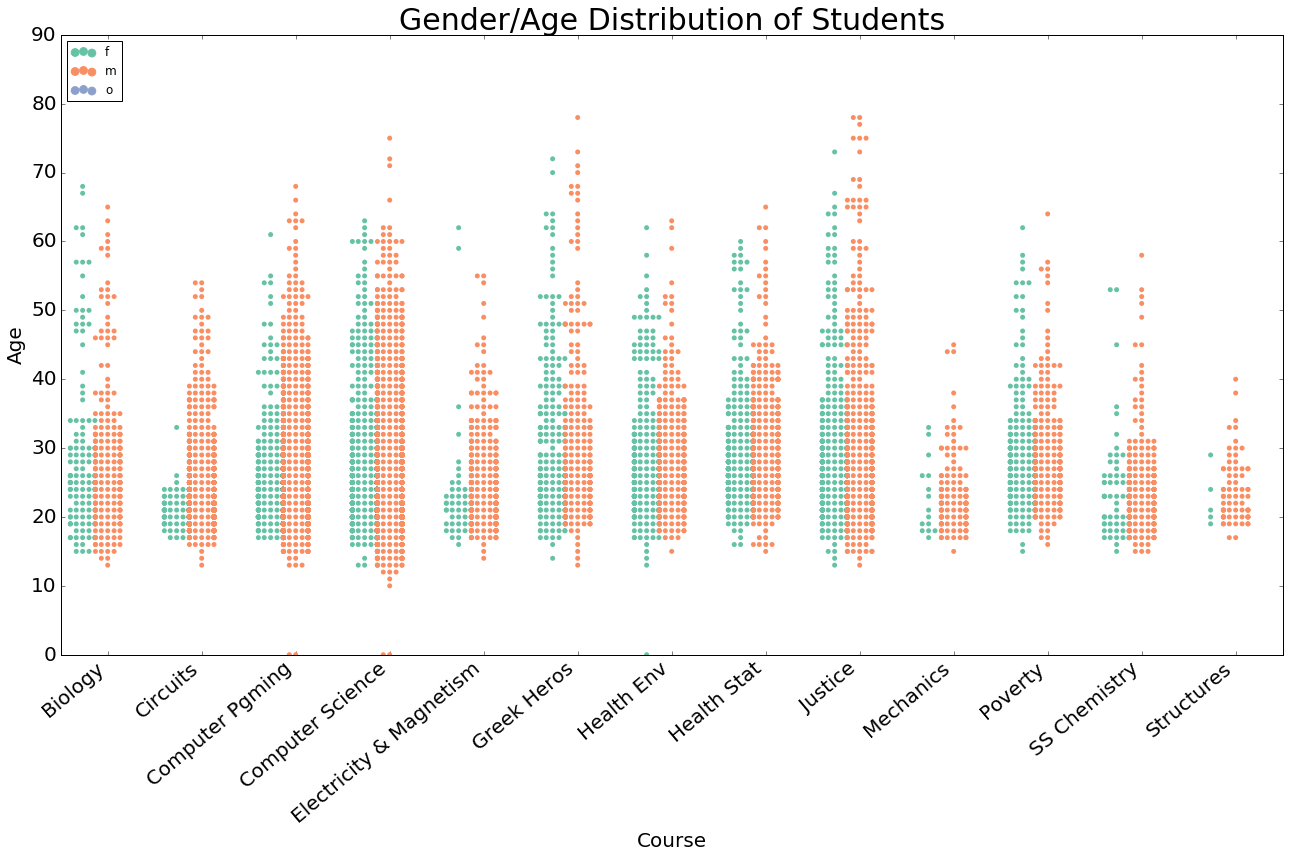

In [92]:
%matplotlib inline
plt.figure(figsize=(18,12))
ax = sb.swarmplot(x="course", y="age", hue="gender", data=data_trim,palette="Set2", dodge=True)
ax.set(ylim=(0,90))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axes.set_title('Gender/Age Distribution of Students',fontsize=30)
ax.tick_params(labelsize=20)
ax.set_ylabel('Age',fontsize=20)
ax.set_xlabel('Course',fontsize=20)
ax.legend(ncol=1, loc='upper left');
plt.tight_layout()

# Observations
* subset of 10000 datapoints used in this plot 
* students with ages < 10 enrolled in some courses (data needs further cleanup)

# Lets explore the details for the computer course as it makes up roughly 20%?? of the dataset 

In [175]:
# extract the computer course participant details and then get a random sample of 10000 data points for visualization 
csdata = data[data['course'].str.contains("Computer")]
rdm = np.random.choice(len(csdata), replace=False, size=10000)
csdata_trim = csdata.iloc[rdm]
print(len(csdata))

245605


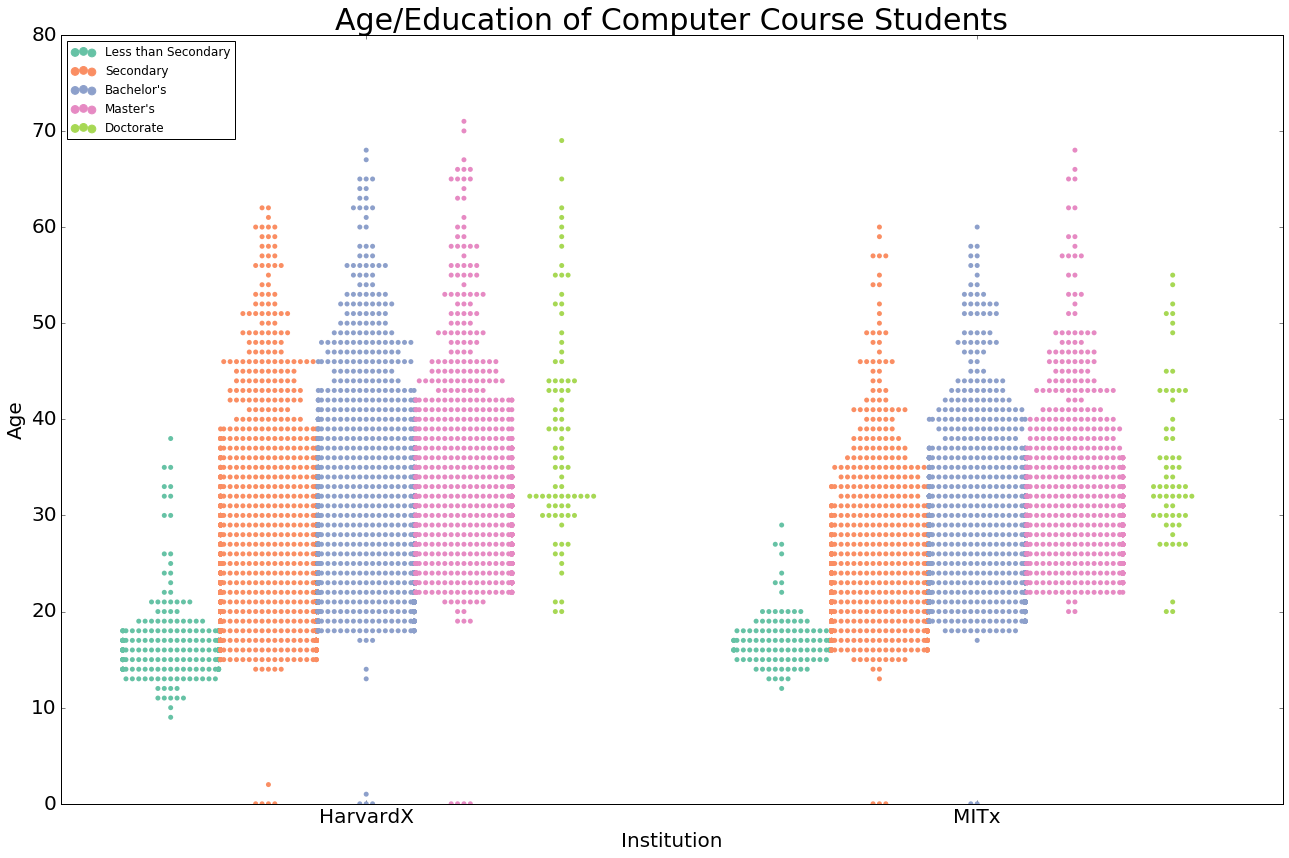

In [177]:
# Age distribution for  CS students
%matplotlib inline
plt.figure(figsize=(18,12))

ax = sb.swarmplot(x="institution", y="age", hue="education", data=csdata_trim,palette="Set2", dodge=True)
ax.set(ylim=(0,None))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axes.set_title('Age/Education of Computer Course Students',fontsize=30)
ax.tick_params(labelsize=20)
ax.set_ylabel('Age',fontsize=20)
ax.set_xlabel('Institution',fontsize=20)
ax.legend(ncol=1, loc='upper left');
plt.tight_layout()

In [178]:
csdata.head()

,institution,course,year,age,user,country,education,YoB,gender,start-time,grade,viewed,explored,nevents,ndays_act,nplay_video,nchapters,certified,registered,incomplete_flag
19329,HarvardX,Computer Science,2012,0,MHxPC130288276,United States,Secondary,2012,m,2013-08-30,0.0,0,0,0,0,0,0,0,1,0.0
19330,HarvardX,Computer Science,2012,25,MHxPC130422039,Unknown/Other,Secondary,1987,m,2012-07-24,0.0,0,0,0,0,0,0,0,1,0.0
19331,HarvardX,Computer Science,2012,44,MHxPC130407931,United States,Secondary,1968,f,2012-07-24,0.0,0,0,0,0,0,0,0,1,0.0
19333,HarvardX,Computer Science,2012,34,MHxPC130064950,Unknown/Other,Master's,1978,m,2012-07-24,0.0,0,0,0,0,0,0,0,1,0.0
19335,HarvardX,Computer Science,2012,24,MHxPC130202970,United States,Bachelor's,1988,m,2012-07-24,0.0,1,0,8,1,0,1,0,1,0.0


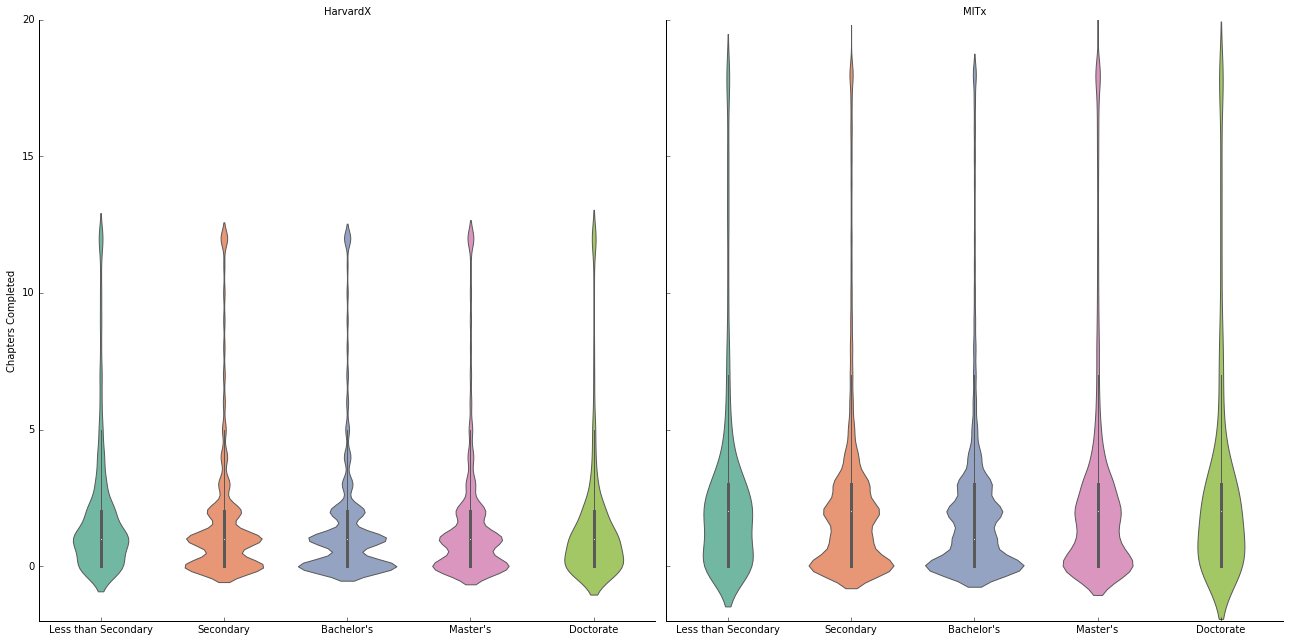

In [219]:
# 
%matplotlib inline
plt.figure(figsize=(18,12))
g=sb.factorplot(col="institution", y="nchapters",x="education",palette="Set2",data=csdata, kind='violin',size=9, aspect=1);
(g.set_axis_labels("", "Chapters Completed")
   .set(ylim=(-2, 20))
#   .set_xticklabels(edu,rotation=90, ha="right")
   .set_titles("{col_name}"))

#ax.axes.set_title('Age/Education of Computer Course Students',fontsize=30)
plt.tight_layout()

# Observations
* subset of 10000 datapoints used in this plot 
* students with ages < 10 enrolled in some courses (data needs further cleanup)

# Stats on Registrations/Certifications/Completion Rate
* Lets plot the course wise breakup of student registrations and certification rates


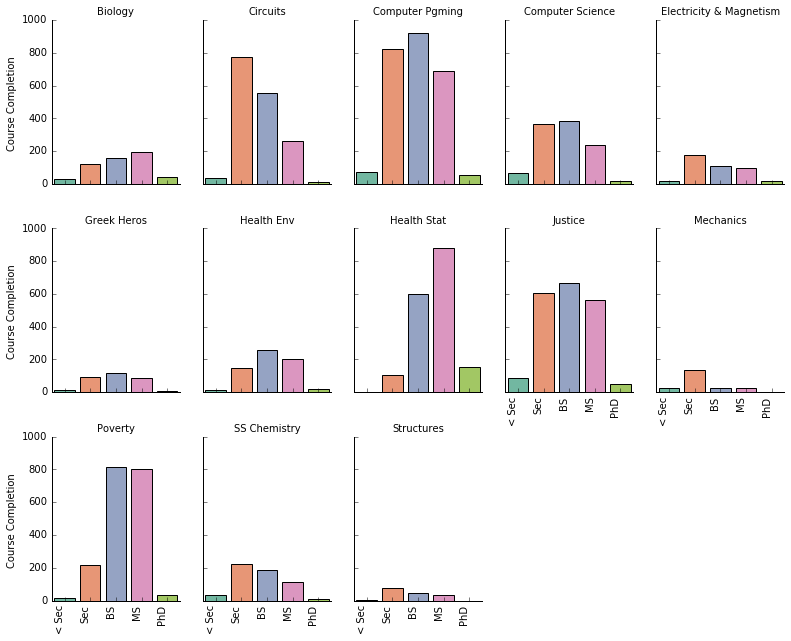

In [227]:
aggregations = { 'certified':'sum','registered':'sum','viewed':'sum'}

%matplotlib inline

course_data = data.groupby(['course','institution','education'],as_index=False).agg(aggregations)
course_data['rate'] = [ int(100 * x.certified / x.registered) for index, x in course_data.iterrows() ]

edu = ["< Sec","Sec","BS","MS","PhD"]

plt.figure(figsize=(18,12))
g=sb.factorplot(col="course", y="certified",x='education',palette="Set2",data=course_data, kind='bar',col_wrap=5,size=3, aspect=.75);
(g.set_axis_labels("", "Course Completion ")
   .set_xticklabels(edu,rotation=90, ha="right")
   .set_titles("{col_name}"))

plt.tight_layout()



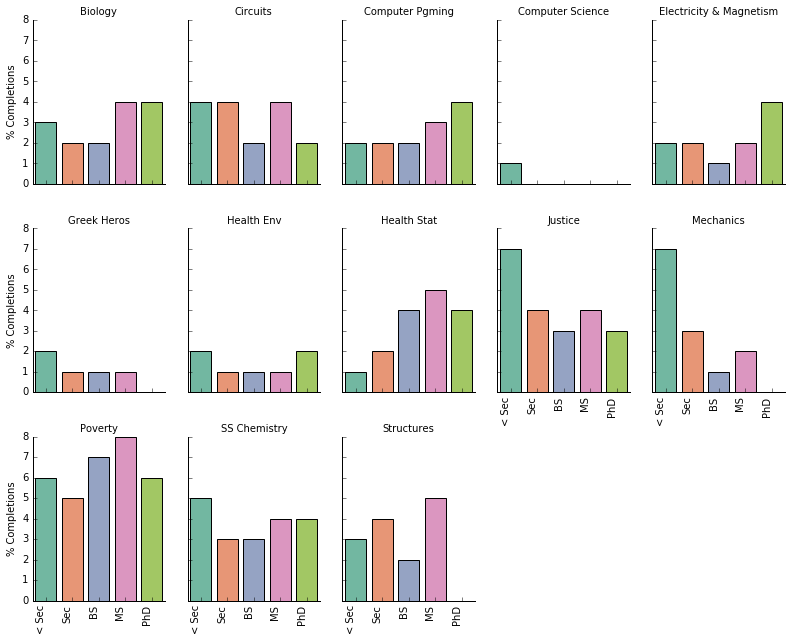

In [228]:

edu = ["< Sec","Sec","BS","MS","PhD"]

plt.figure(figsize=(18,12))
g=sb.factorplot(col="course", y="rate",x='education',palette="Set2",data=course_data, kind='bar',col_wrap=5,size=3, aspect=.75);
(g.set_axis_labels("", "% Completions")
   .set_xticklabels(edu,rotation=90, ha="right")
#   .set_title('Course Completion by Course and Education level',fontsize=30)
   .set_titles("{col_name}"))


plt.tight_layout()



# Other plots on the dataset 
* Country wise information on courses completed/certification rates
* education wise information on courses completed/


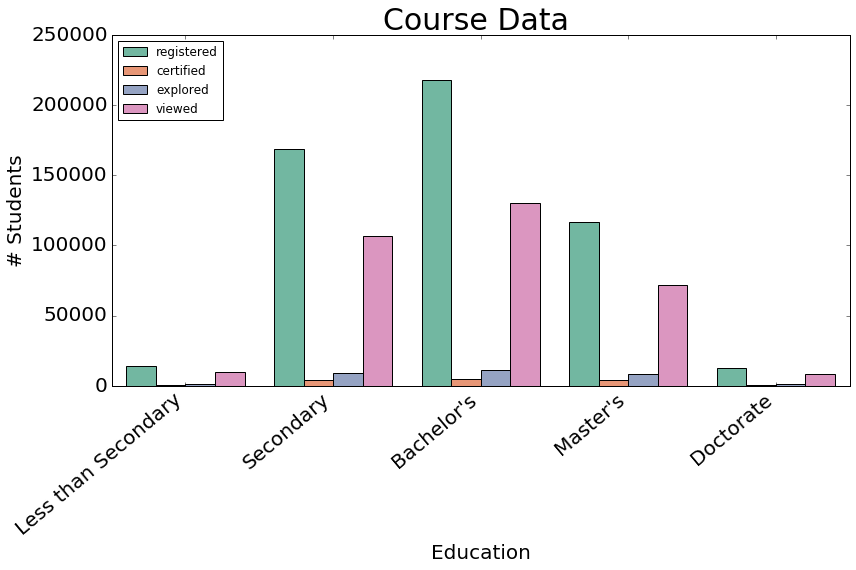

In [238]:
aggregations = { 'certified':'sum','registered':'sum','viewed':'sum','explored':'sum'}

%matplotlib inline

cdata = data.groupby(['education'],as_index=False).agg(aggregations)

tidydata = (
    cdata.set_index('education')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

%matplotlib inline
plt.figure(figsize=(12,8))
ax=sb.barplot(x='education', y='Value', hue='Variable', data=tidydata,palette="Set2")

ax.set(ylim=(0,None))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.axes.set_title('Course Data ',fontsize=30)
ax.tick_params(labelsize=20)
ax.set_ylabel('# Students',fontsize=20)
ax.set_xlabel('Education',fontsize=20)
ax.legend(ncol=1, loc='upper left');
plt.tight_layout()

[<matplotlib.text.Text at 0x14f549780>, <matplotlib.text.Text at 0x14f351160>]

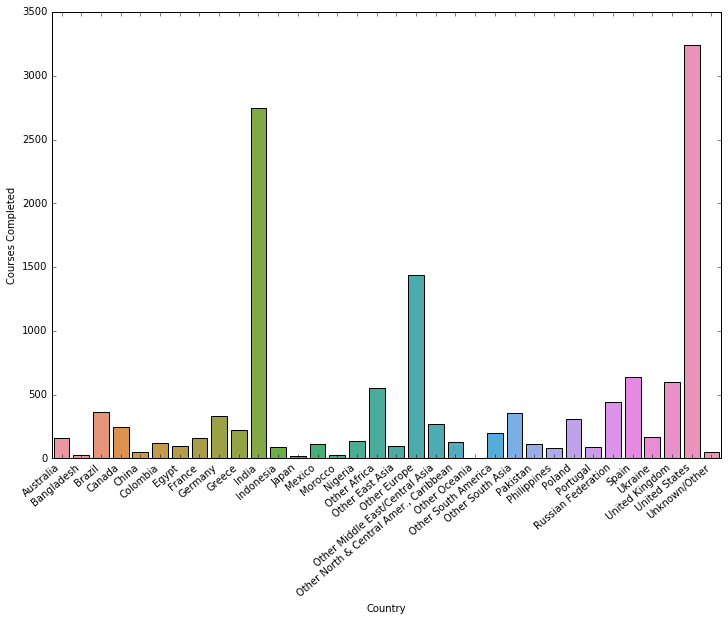

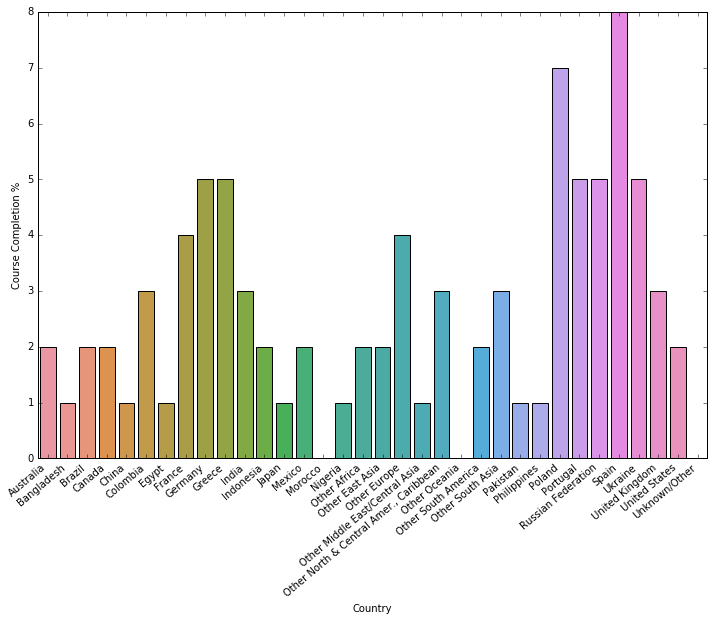

In [231]:
%matplotlib inline
# Extract the country specific data and calculate the % %certification rate
country_data = data[['country','certified','registered']].groupby('country',as_index=False).sum()
country_data['rate'] = [ int(100 * x.certified / x.registered) for index, x in country_data.iterrows() ]

plt.figure(figsize=(12,8))
ax=sb.barplot(x="country", y="certified", data=country_data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='Country', ylabel='Courses Completed')
#plt.tight_layout()

plt.figure(figsize=(12,8))
ax=sb.barplot(x="country", y="rate", data=country_data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='Country', ylabel='Course Completion %')
#plt.tight_layout()


[<matplotlib.text.Text at 0x1519c82e8>, <matplotlib.text.Text at 0x1519b4d30>]

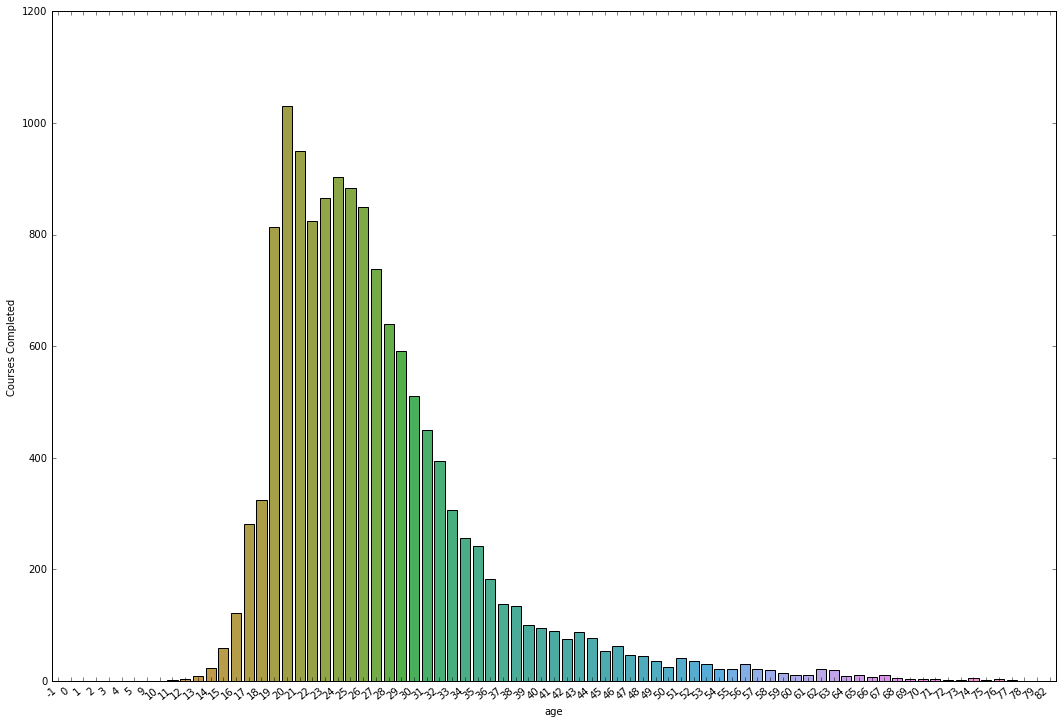

In [236]:
%matplotlib inline
# Extract the AGE specific data and calculate the % %certification rate
age_data = data[['age','certified','registered']].groupby('age',as_index=False).sum()
age_data['rate'] = [ int(100 * x.certified / x.registered) for index, x in age_data.iterrows() ]

plt.figure(figsize=(18,12))
#plt.figure(figsize=(12,8))
ax=sb.barplot(x="age", y="certified", data=age_data);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='age', ylabel='Courses Completed')
#plt.tight_layout()


# Observations
* 
* 

In [ ]:
# Following CODE Segment for Regression / Model needs to be finetuned

In [ ]:
# CONVERT CATEGORICAL DATA TO NUMERIC
encoder = LabelEncoder()
ccode = encoder.fit_transform(data['country'])
cscode = encoder.fit_transform(data['course'])
educode = encoder.fit_transform(data['education'])
gendercode=encoder.fit_transform(data['gender'])
usercode=encoder.fit_transform(data['user'])

# Eliminate the categorical data and use the encoded information 
data.drop(['course','country','education','YoB','gender','registered','user'],axis=1,inplace=True)

data.insert(0,"user-code",usercode)
data.insert(1,"country-code",ccode)
data.insert(2,"course-code",cscode)
data.insert(3,"education-code",educode)
data.insert(4,"gender-code",gendercode)
data.head(10)



In [ ]:
data.corr()

In [ ]:
sb.heatmap(data.corr())

In [ ]:
#Build the logistic regression model
# with course','country','education','age','gender' as the independent variables

X = data.ix[:,(0,1,2,3,4,5,6,7,8,9,10)].values
y = data.ix[:,11].values


print(X)

# Split the dataset into test and training set with 30/70 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

LogReg = LogisticRegression()

LogReg.fit(X_train, y_train)

# Print trained model intercept and trained model coefficients


print(LogReg.intercept_)
print(LogReg.coef_)
    
# Predict the resukts on test data  
y_pred = LogReg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Print the metrics 
print(cm)
print(classification_report(y_test, y_pred))

# Generate table of predictions vs actual
pd.crosstab(y_pred,y_test)


In [ ]:
# Try the DecisionTree 

TreeReg = DecisionTreeRegressor()
TreeReg.fit(X_train, y_train)


# Predict the results on test data  
y_hat = TreeReg.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(rmse)
# Generate table of predictions vs actual
pd.crosstab(y_hat,y_test)




In [ ]:
from sklearn.model_selection import cross_val_score
result=cross_val_score(TreeReg,X_train, y_train,scoring="neg_mean_squared_error",cv=10)
rmse_result=np.sqrt(-result)

In [ ]:
print("Scores : ",result)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
ForestReg = RandomForestRegressor()
ForestReg.fit(X_train,y_train)

y_hatf = ForestReg.predict(X_test)
fmse = mean_squared_error(y_test, y_hatf)
f_rmse = np.sqrt(fmse)
print(f_rmse)
# Generate table of predictions vs actual
pd.crosstab(y_hatf,y_test)



In [ ]:
# Alternatives to TRY OUT 

#Feature scaling - to standardscaling or minmaxscaling on attribs
#Instead of random test/train split use time based split 
#oversample the minority / undersample the majority class
#GridSearch 